In [1]:
# Importing Numpy, OpenCV and Matplotlib
import cv2  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import kneed

In [2]:
# Loading test images
test_Shift0 = cv2.imread('./images/TestSeq/Shift0.png', cv2.IMREAD_GRAYSCALE)
test_ShiftR2 = cv2.imread('./images/TestSeq/ShiftR2.png', cv2.IMREAD_GRAYSCALE)
test_ShiftR10 = cv2.imread('./images/TestSeq/ShiftR10.png', cv2.IMREAD_GRAYSCALE)
test_ShiftR20 = cv2.imread('./images/TestSeq/ShiftR20.png', cv2.IMREAD_GRAYSCALE)
test_ShiftR40 = cv2.imread('./images/TestSeq/ShiftR40.png', cv2.IMREAD_GRAYSCALE)
test_ShiftR5U5 = cv2.imread('./images/TestSeq/ShiftR5U5.png', cv2.IMREAD_GRAYSCALE)
#plt.imshow(test_Shift0, cmap='gray', vmin = 0, vmax = 255)

## 1. Gaussian and Laplacian Pyramids

In [3]:
ds1_img1 = cv2.imread('./images/DataSeq1/yos_img_01.jpg', cv2.IMREAD_GRAYSCALE)
ds1_img2 = cv2.imread('./images/DataSeq1/yos_img_02.jpg', cv2.IMREAD_GRAYSCALE)
ds1_img3 = cv2.imread('./images/DataSeq1/yos_img_03.jpg', cv2.IMREAD_GRAYSCALE)
#plt.imshow(ds1_img1, cmap='gray', vmin = 0, vmax = 255)

### 1.1. REDUCE

In [4]:
def REDUCE(image, pattern = 5):
    blurred = cv2.GaussianBlur(image, (pattern, pattern), 0, cv2.BORDER_REFLECT)
    return blurred[::2, ::2]

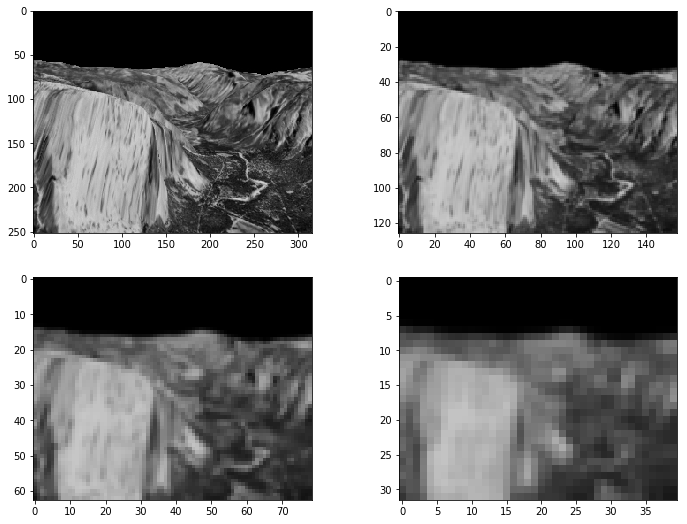

In [5]:
ds1_img1_gpyr0 = ds1_img1
ds1_img1_gpyr1 = REDUCE(ds1_img1_gpyr0)
ds1_img1_gpyr2 = REDUCE(ds1_img1_gpyr1)
ds1_img1_gpyr3 = REDUCE(ds1_img1_gpyr2)

plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(ds1_img1_gpyr0, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(ds1_img1_gpyr1, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(ds1_img1_gpyr2, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(ds1_img1_gpyr3, cmap='gray', vmin = 0, vmax = 255)

The images are shown with the same scale to be visible. We note that the first one ($G_0$) has a width of over 300px, while the fourth one ($G_3$) has a width just under 40 pixels.

### 1.2. EXPAND

In [6]:
def EXPAND(image):
    blowup = np.zeros((2*image.shape[0], 2*image.shape[1]))
    #padding to handle borders underflow/overflow
    pad = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE, None) 
    
    even_even = np.outer([0.125, 0.75, 0.125], [0.125, 0.75, 0.125])
    odd_odd = np.outer([0.5]*2, [0.5]*2)
    even_odd = np.outer([0.125, 0.75, 0.125], [0.5]*2)
    odd_even = np.outer([0.5]*2, [0.125, 0.75, 0.125])

    for row in np.arange(blowup.shape[0]):
        for col in np.arange(blowup.shape[1]):
            if row%2 == 0 and col%2 == 0:
                blowup[row, col] = np.multiply(even_even, pad[row/2:row/2+3, col/2:col/2+3]).sum()
            elif row%2 == 1 and col%2 == 1:
                blowup[row, col] = np.multiply(odd_odd, pad[row/2+1:row/2+3, col/2+1:col/2+3]).sum()
            elif row%2 == 0 and col%2 == 1:
                blowup[row, col] = np.multiply(even_odd, pad[row/2:row/2+3, col/2+1:col/2+3]).sum()
            elif row%2 == 1 and col%2 == 0:
                blowup[row, col] = np.multiply(odd_even, pad[row/2+1:row/2+3, col/2:col/2+3]).sum()
    return blowup

In [7]:
def Laplacian_pyramid(G0, level=1):
    levels = np.arange(level)
    gauss_pyr = [G0]
    for i in levels:
        gauss_pyr.append(REDUCE(gauss_pyr[i]))
    
    reverse_pyr = [gauss_pyr[level]]
    for i in levels:
        reverse_pyr.append(EXPAND(reverse_pyr[i]))

    laplacian_pyr = []
    for i in levels[:-1]:
        g = gauss_pyr[i].astype(np.float)
        r_g = reverse_pyr[level - i].astype(np.float)
        laplacian_pyr.append(g - r_g[:g.shape[0], :g.shape[1]]) #size discr. fix
    
    return laplacian_pyr, gauss_pyr[level]

In [8]:
[ds1_img1_lpyr0, ds1_img1_lpyr1, ds1_img1_lpyr2], ds1_img1_g3 = Laplacian_pyramid(ds1_img1, 4)

In [9]:
def diffTo255(gradient_image):
    matrix = gradient_image - np.min(gradient_image)
    return ((matrix.astype(np.float32) / np.max(matrix))*255).astype(np.uint8)

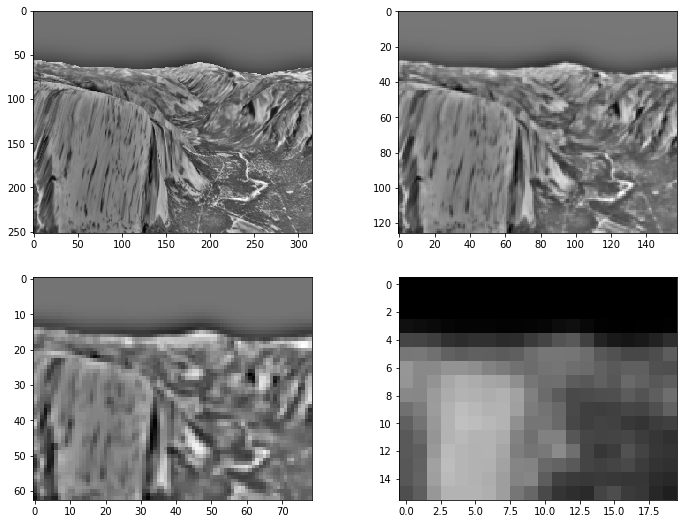

In [10]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(diffTo255(ds1_img1_lpyr0), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(diffTo255(ds1_img1_lpyr1), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(diffTo255(ds1_img1_lpyr2), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(ds1_img1_g3, cmap='gray', vmin = 0, vmax = 255)

Because some of the Laplacian images have negative values as a result of image differences, we apply a function (only at the visualization step) in order to rescale them in the $[0,255]$ range.  
The first three images are $L_0$, $L_1$, $L_2$, the Laplacian images of the pyramid, shown at the same scale. The fourth image is $G_3$, the Gaussian image after 3 $\texttt{REDUCE}$ operations.

## 2. Lucas Kanade optic flow

In [11]:
def gradient(image, alongX = True, scale = 1):
    image = image.astype(np.int32)
    return image[scale:] - image[:-1*scale] if alongX else image[:,scale:] - image[:,:-1*scale]

In [12]:
def gradient_t(image_0, image_t):
    return image_t.astype(np.int32) - image_0.astype(np.int32)

### 2.1. LK optic flow estimation (ShiftR2 & ShiftR5U5)

In [13]:
def LK(image_0, image_t, neighborhood = 5, gauss_sigma = 4, filter_size = 11):  
    if gauss_sigma is None and filter_size is None:
        image_0_blur = image_0
        image_t_blur = image_t
    else:
        image_0_blur = cv2.GaussianBlur(image_0, (filter_size, filter_size), gauss_sigma, cv2.BORDER_REFLECT)
        image_t_blur = cv2.GaussianBlur(image_t, (filter_size, filter_size), gauss_sigma, cv2.BORDER_REFLECT)
    Gradx = gradient(image_0_blur)
    Grady = gradient(image_0_blur, alongX = False)
    Gradt = gradient_t(image_0_blur, image_t_blur)


    #code to fill with zeros
    Gradx_pad = np.zeros_like(image_0, dtype=np.float32)
    margin = image_0.shape[0] - Gradx.shape[0]
    Gradx_pad[margin:] = Gradx.copy()
    Grady_pad = np.zeros_like(image_0, dtype=np.float32)
    margin = image_0.shape[1] - Grady.shape[1]
    Grady_pad[:, margin:] = Grady.copy()
    Gradx = Gradx_pad
    Grady = Grady_pad
    
    #to avoid repeating operations within loop
    Gradx_sq = Gradx ** 2 
    Grady_sq = Grady ** 2 
    Gradx_times_Grady = np.multiply(Gradx, Grady)
    Gradx_times_Gradt = np.multiply(Gradx, Gradt)
    Grady_times_Gradt = np.multiply(Grady, Gradt)

    margin = (neighborhood - 1) /2
    U = np.zeros((image_0.shape[0], image_0.shape[1]), dtype = np.float32)
    V = np.zeros((image_0.shape[0], image_0.shape[1]), dtype = np.float32)

    for row in np.arange(margin, image_0.shape[0] - margin):
        for col in np.arange(margin, image_0.shape[1] - margin):
            It = Gradt[row-margin:row+margin+1, col-margin:col+margin+1]
            Ix = Gradx[row-margin:row+margin+1, col-margin:col+margin+1]
            Iy = Grady[row-margin:row+margin+1, col-margin:col+margin+1]
            Ix_sq = Gradx_sq[row-margin:row+margin+1, col-margin:col+margin+1]
            Iy_sq = Grady_sq[row-margin:row+margin+1, col-margin:col+margin+1]
            Ix_times_Iy = Gradx_times_Grady[row-margin:row+margin+1, col-margin:col+margin+1]
            Ix_times_It = Gradx_times_Gradt[row-margin:row+margin+1, col-margin:col+margin+1]
            Iy_times_It = Grady_times_Gradt[row-margin:row+margin+1, col-margin:col+margin+1]
            
            A = np.array((np.sum(Ix_sq), np.sum(Ix_times_Iy), \
                          np.sum(Ix_times_Iy), np.sum(Iy_sq))).reshape(2,2)
            
            # Compute second member
            b = np.array((-np.sum(Ix_times_It), -np.sum(Iy_times_It))).reshape(2,1)
            
            res =  np.linalg.lstsq(A, b, rcond = None)[0]
            [U[row, col], V[row, col]] = res
    
    return U, V

In [14]:
def quiver_plot(U, V, image, discr_step=25, showFig = False, pltObj=None):
    cols = np.linspace(0, U.shape[1]-1, discr_step).astype(np.int32)
    rows = np.linspace(0, U.shape[0]-1, discr_step).astype(np.int32)
    discrete = np.array([[r, c] for c in cols for r in rows]).reshape(-1,2)

    U = U[discrete[:,0], discrete[:,1]]
    V = V[discrete[:,0], discrete[:,1]]
    
    if pltObj is None:
        plt.figure()
        #ax = plt.gca()
    plt.imshow(image, cmap="gray")
    plt.quiver(discrete[:,1], discrete[:,0], V, -U, color='r', headwidth=5)

    if showFig:
        plt.show()

    return plt

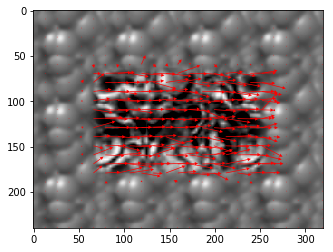

<module 'matplotlib.pyplot' from 'C:\Python27\lib\site-packages\matplotlib\pyplot.pyc'>

In [15]:
U_ShiftR2, V_ShiftR2 = LK(test_Shift0, test_ShiftR2, neighborhood=9, gauss_sigma = 3, filter_size = 11)
quiver_plot(U_ShiftR2, V_ShiftR2, test_Shift0, showFig = True)

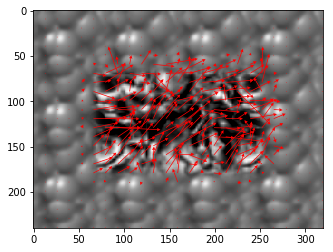

<module 'matplotlib.pyplot' from 'C:\Python27\lib\site-packages\matplotlib\pyplot.pyc'>

In [16]:
U_ShiftR5U5, V_ShiftR5U5 = LK(test_Shift0, test_ShiftR5U5, neighborhood=17, gauss_sigma = 3, filter_size = 11)
quiver_plot(U_ShiftR5U5, V_ShiftR5U5, test_Shift0, showFig = True)

In both cases, the images were smoothed using a Gaussian filter of $11\times11$ and $\sigma = 3$. 
  
In the case of ShiftR2 (shift to the right of 2 pixels), the displacements were relatively well estimated. Almost all pixels agree on a single direction to the right, even though there are a few oddities. For example, one pixel outside of the rectangle that is moving has an estimated displacement towards the up direction. This might be a side-effect of smoothing.  
In the case of ShiftR5U5, the estimation is more cahotic. Even if there is a general trend of a displacement towards the top-right, there is no single, clear direction. Some are more oriented towards the right and some, more towards the top. A couple of pixels give us an estimation of a displacement towards the bottom right.  
Because the (known) displacement is of 5 instead of 2 in the first case, we adapt our neighborhood to consider the 17 pixels-window centered on each pixel.

### 2.2. LK optic flow estimation (ShiftR10, ShiftR20 & ShiftR40)

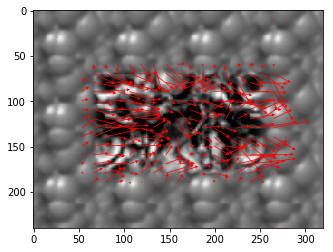

<module 'matplotlib.pyplot' from 'C:\Python27\lib\site-packages\matplotlib\pyplot.pyc'>

In [17]:
U_ShiftR10, V_ShiftR10 = LK(test_Shift0, test_ShiftR10, neighborhood=25, gauss_sigma = 3, filter_size = 11)
quiver_plot(U_ShiftR10, V_ShiftR10, test_Shift0, showFig = True)

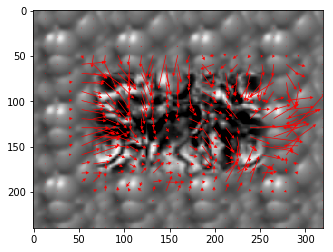

<module 'matplotlib.pyplot' from 'C:\Python27\lib\site-packages\matplotlib\pyplot.pyc'>

In [18]:
U_ShiftR20, V_ShiftR20 = LK(test_Shift0, test_ShiftR20, neighborhood=51, gauss_sigma = 3, filter_size = 11)
quiver_plot(U_ShiftR20, V_ShiftR20, test_Shift0, showFig = True)

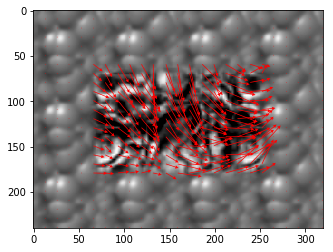

<module 'matplotlib.pyplot' from 'C:\Python27\lib\site-packages\matplotlib\pyplot.pyc'>

In [19]:
U_ShiftR40, V_ShiftR40 = LK(test_Shift0, test_ShiftR40, neighborhood=111, gauss_sigma = 3, filter_size = 11)
quiver_plot(U_ShiftR40, V_ShiftR40, test_Shift0, showFig = True)

In all three cases, the images were smoothed using the same Gaussian filter as previously (of size $11\times11$ and $\sigma = 3$). 

As we can see in these three examples, the bigger the motion, the harder it becomes to accurately estimate the optical flow. The "classic" Lucas-Kanade method assumes small displacements between the two images of the sequence, which is not verified here.  
While the majority of quiver arrows point towards the same direction (right displacement) on the 10-pixel shifted image pair, there is a lot of noise compared to the previous two examples.  
This fails completely in the case of 20 and 40-pixel shifts: either no general direction can be infered or an odd, non-linear motion is found.

### 2.3. LK optic flow estimation (DataSeq1)

In [20]:
def Warp(image2, vx, vy):
    map1 = vx + np.array(np.arange(image2.shape[0])).reshape(-1, 1)
    map2 = vy + np.array(np.arange(image2.shape[1])).reshape(1, -1)

    #CV_16SC2 , CV_32FC1 , or CV_32FC2
    return cv2.remap(image2, map2.astype(np.float32), map1.astype(np.float32), cv2.INTER_NEAREST)

In [21]:
def perLevelLK(image1, image2, level = 0, seq_name = ""):
    image1_pyr = [image1]
    image2_pyr = [image2]
    for i in np.arange(level):
        image1_pyr.append(REDUCE(image1_pyr[i]))
        image2_pyr.append(REDUCE(image2_pyr[i]))
                
        i1 = np.array(image1_pyr[i])
        i2 = np.array(image2_pyr[i])
        U, V = LK(i1, i2, neighborhood=11, gauss_sigma = 3, filter_size = 11)

        plt.figure(figsize=(12, 9))
        plt.gcf().suptitle("Sequence: {} - Level {}:".format(seq_name, i))
        plt.subplot(2,2,1)
        quiver_plot(U, V, i1, showFig = False, pltObj = plt)
        plt.title('First in sequence & Quiver plot');
        plt.subplot(2,2,2)
        plt.imshow(Warp(i2, U, V), cmap='gray', vmin = 0, vmax = 255)
        plt.title('Second in sequence after warp');
        plt.subplot(2,2,3)
        plt.imshow(cv2.subtract(i1, i2), cmap='gray', vmin = 0, vmax = 255)
        plt.title('Image difference without warp');
        plt.subplot(2,2,4)
        plt.imshow(cv2.subtract(i1, Warp(i2, U, V)), cmap='gray', vmin = 0, vmax = 255)
        plt.title('Image difference with warp');
        plt.show()

In [22]:
def singleLevelLK(image1, image2, level = 0, seq_name = ""):
    image1_pyr = [image1]
    image2_pyr = [image2]
    for i in np.arange(level):
        image1_pyr.append(REDUCE(image1_pyr[i]))
        image2_pyr.append(REDUCE(image2_pyr[i]))
                
    i1 = np.array(image1_pyr[level])
    i2 = np.array(image2_pyr[level])
    U, V = LK(i1, i2, neighborhood=11, gauss_sigma = 3, filter_size = 11)

    plt.figure(figsize=(12, 9))
    plt.gcf().suptitle("Sequence: {} - Level {}:".format(seq_name, level))
    plt.subplot(2,2,1)
    quiver_plot(U, V, i1, showFig = False, pltObj = plt)
    plt.title('First in sequence & Quiver plot');
    plt.subplot(2,2,2)
    plt.imshow(Warp(i2, U, V), cmap='gray', vmin = 0, vmax = 255)
    plt.title('Second in sequence after warp');
    plt.subplot(2,2,3)
    plt.imshow(cv2.subtract(i1, i2), cmap='gray', vmin = 0, vmax = 255)
    plt.title('Image difference without warp');
    plt.subplot(2,2,4)
    plt.imshow(cv2.subtract(i1, Warp(i2, U, V)), cmap='gray', vmin = 0, vmax = 255)
    plt.title('Image difference with warp');
    plt.show()

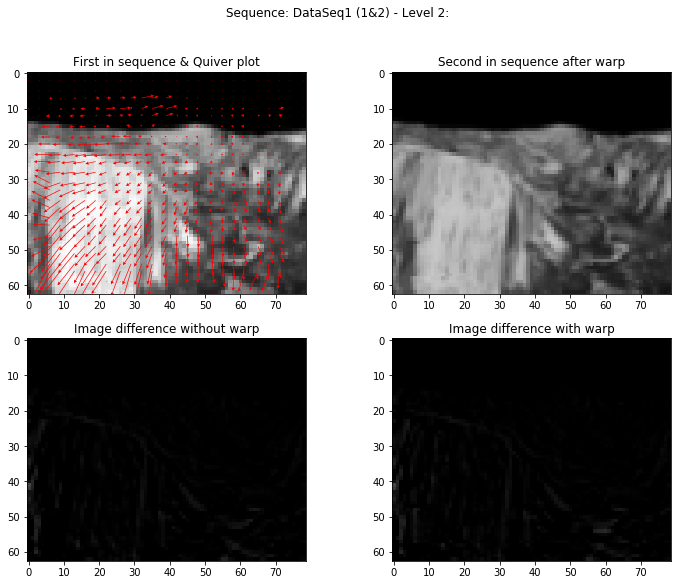

In [23]:
singleLevelLK(ds1_img1, ds1_img2, 2, seq_name = "DataSeq1 (1&2)")

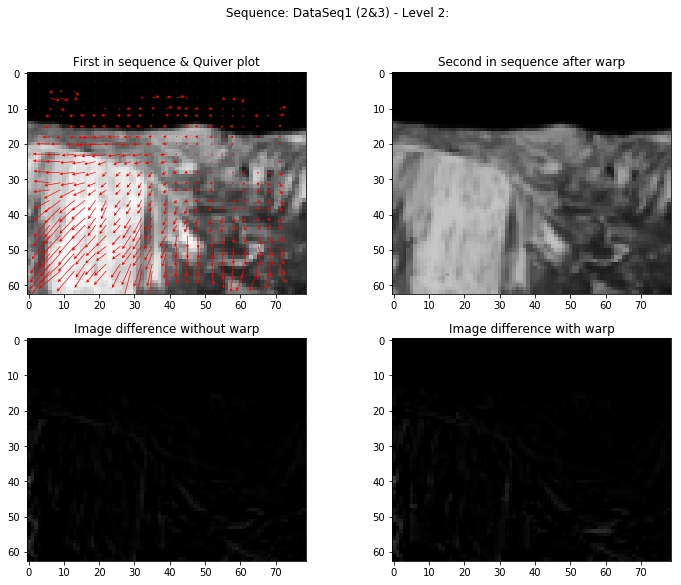

In [24]:
singleLevelLK(ds1_img2, ds1_img3, 2, seq_name = "DataSeq1 (2&3)")

In both pairs of the sequence (from 1 to 2 and from 2 to 3), Level 2 of the Gaussian pyramids allows us to reduce the most the error in image differences.  
Some notable areas where it fails a bit are on the left border of the image, which can be seen in the difference images, most likely because we don't actually retrieve this area from one image to the next.

In [25]:
ds2_img0 = cv2.imread('./images/DataSeq2/0.png', cv2.IMREAD_GRAYSCALE)
ds2_img1 = cv2.imread('./images/DataSeq2/1.png', cv2.IMREAD_GRAYSCALE)
ds2_img2 = cv2.imread('./images/DataSeq2/2.png', cv2.IMREAD_GRAYSCALE)
#plt.imshow(ds2_img0, cmap='gray', vmin = 0, vmax = 255)

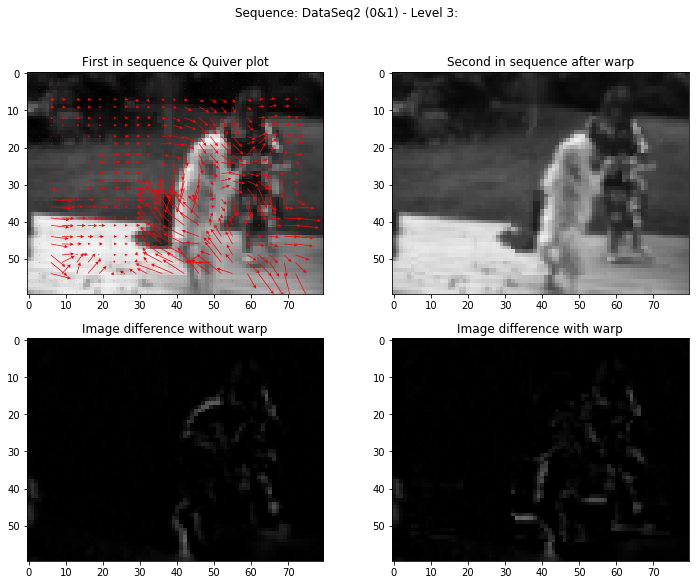

In [26]:
singleLevelLK(ds2_img0, ds2_img1, 3, seq_name = "DataSeq2 (0&1)")

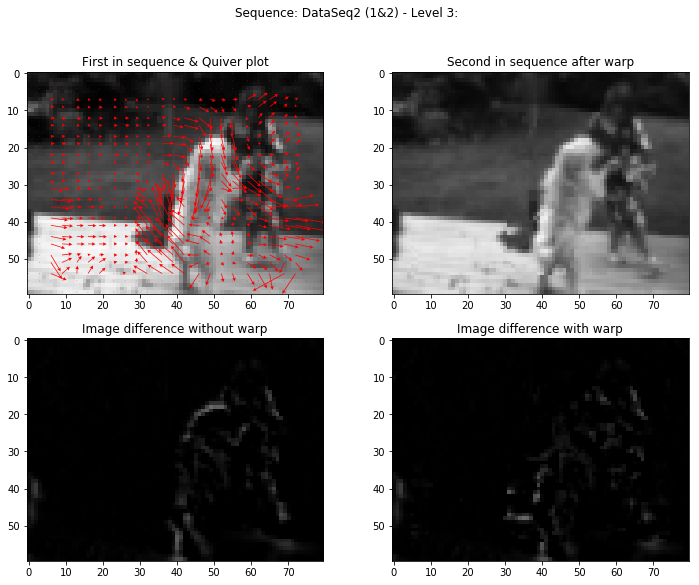

In [27]:
singleLevelLK(ds2_img1, ds2_img2, 3, seq_name = "DataSeq2 (1&2)")

In both pairs of the sequence (from 1 to 2 and from 2 to 3), Level 3 of the Gaussian pyramids allows us to reduce the most the error in image differences.  
However, compared to the first data sequence, our optical flow estimation is as very good, in poorer warping results (we can actually see the errors in the images this time).  
This might be due to the motion in this example (it was much simpler in the first), with non-linear rotations, etc.

### 3. Hierarchical Lucas-Kanade optic flow

In [28]:
def hierarchicalLK(imageL, imageR, max_level, plot = False, seq_name = ""):
    k = max_level
    
    imageL_pyr = [imageL]
    imageR_pyr = [imageR]
    for i in np.arange(max_level):
        imageL_pyr.append(REDUCE(imageL_pyr[i]))
        imageR_pyr.append(REDUCE(imageR_pyr[i]))
        
    while k >= 0:
        imageL_k = imageL_pyr[k]
        imageR_k = imageR_pyr[k]
        if k == max_level:
            U = np.zeros_like(imageL_k)
            V = np.zeros_like(imageR_k)
        else:
            U = 2*EXPAND(U)
            V = 2*EXPAND(V)
        U = U[:imageR_k.shape[0], :imageR_k.shape[1]]
        V = V[:imageR_k.shape[0], :imageR_k.shape[1]]
        W_k = Warp(imageR_k, U, V)
        Du, Dv = LK(imageL_k, W_k, neighborhood = 5, gauss_sigma=None, filter_size=None)
        U = U + Du
        V = V + Dv
        k -= 1
    
    if plot:
        plt.figure(figsize=(12, 9))
        plt.gcf().suptitle("Sequence: {} - Max Level {}:".format(seq_name, max_level))
        plt.subplot(2,2,1)
        quiver_plot(U, V, imageL, showFig = False, pltObj = plt)
        plt.title('First in sequence & Quiver plot');
        plt.subplot(2,2,2)
        plt.imshow(Warp(imageR, U, V), cmap='gray', vmin = 0, vmax = 255)
        plt.title('Second in sequence after warp');
        plt.subplot(2,2,3)
        plt.imshow(cv2.subtract(imageL, imageR), cmap='gray', vmin = 0, vmax = 255)
        plt.title('Image difference without warp');
        plt.subplot(2,2,4)
        plt.imshow(cv2.subtract(imageL, Warp(imageR, U, V)), cmap='gray', vmin = 0, vmax = 255)
        plt.title('Image difference with warp');
        plt.show()
    
    return U,V

### 3.a. Test Sequence

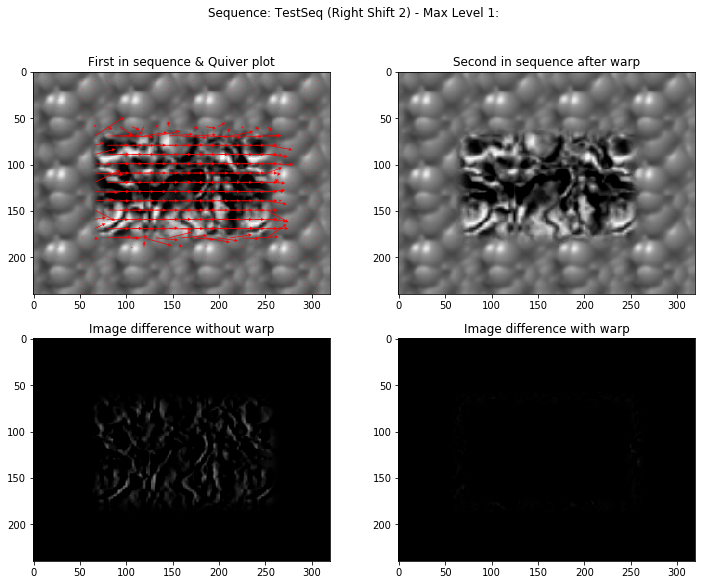

In [29]:
_, _ = hierarchicalLK(test_Shift0, test_ShiftR2, 1, plot = True, seq_name = "TestSeq (Right Shift 2)")

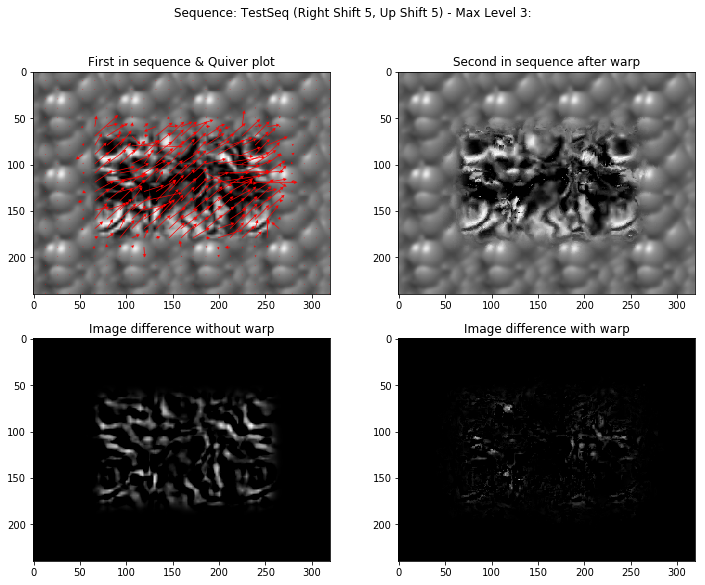

In [30]:
_,_ = hierarchicalLK(test_Shift0, test_ShiftR5U5, 3, plot = True, seq_name = "TestSeq (Right Shift 5, Up Shift 5)")

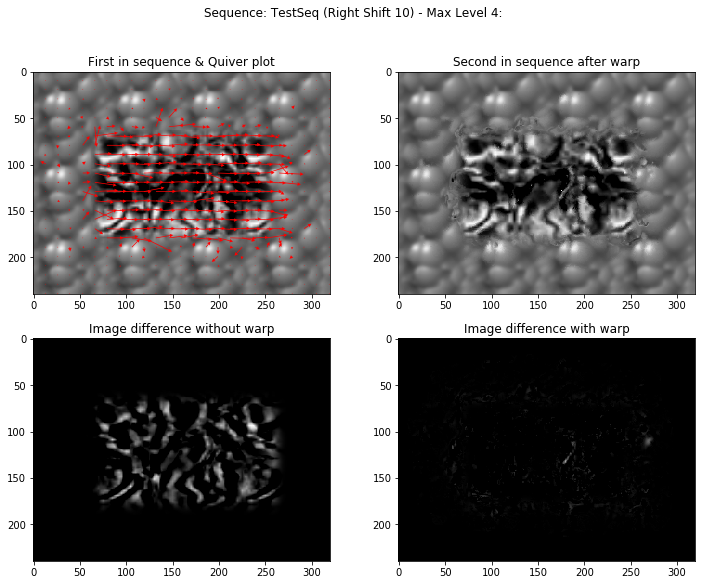

In [31]:
_,_ = hierarchicalLK(test_Shift0, test_ShiftR10, 4, plot = True, seq_name = "TestSeq (Right Shift 10)")

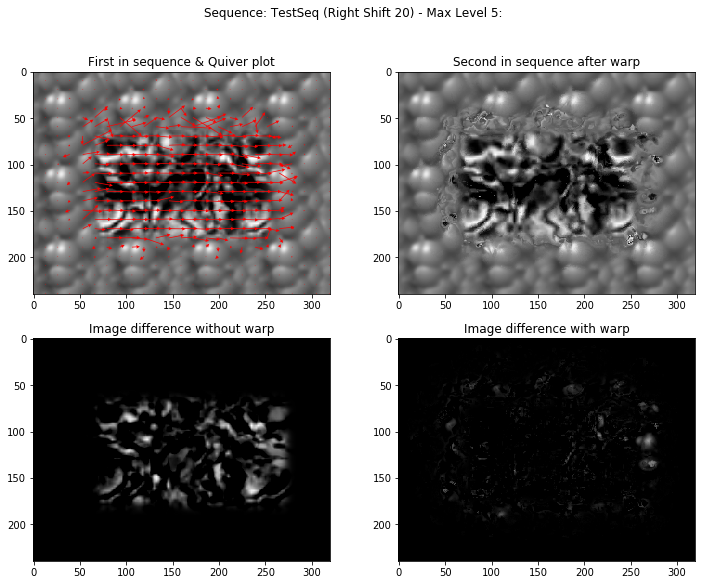

In [32]:
_,_ = hierarchicalLK(test_Shift0, test_ShiftR20, 5, plot = True, seq_name = "TestSeq (Right Shift 20)")

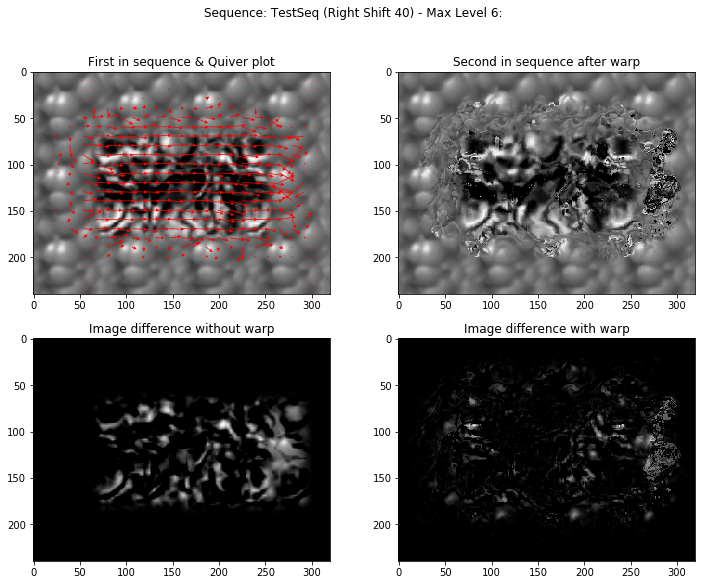

In [33]:
_,_ = hierarchicalLK(test_Shift0, test_ShiftR40, 6, plot = True, seq_name = "TestSeq (Right Shift 40)")

We applied the hierarchical Lucas-Kanade algorithm to each image of the test sequence with the reference image (test_Shift0).  
Each time, we followed the recommendation to use a maximum level of $log_2(\delta)$ when we knew the displacement to be $\delta$.  
In all cases, the quiver plots for the central area look good, with the estimated flow going in the right direction. This translates to good (low) difference images in the central parts.  
However, there is still a lot of noise in the surrounding area, with very high estimated motion, and relatively big errors in the difference images in the parts surrounding the central area.  
This is especially true as the true $\delta$ displacement grows: the errors start to be noticeable with 20 pixel shifts and become significant at 40 pixel shifts.  
  
This being said, the estimated flow is significantly better using hierarchical LK than the "classic" LK method.

### 3.b. Data Sequence 1

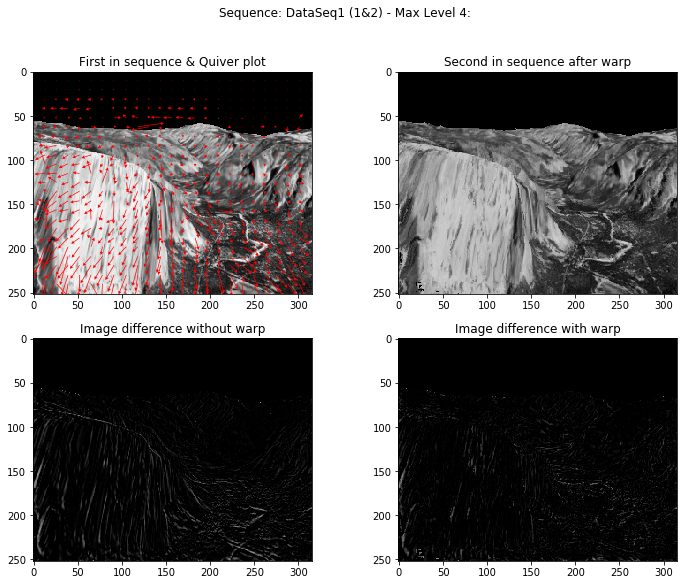

In [34]:
_,_ = hierarchicalLK(ds1_img1, ds1_img2, 4, plot = True, seq_name = "DataSeq1 (1&2)")

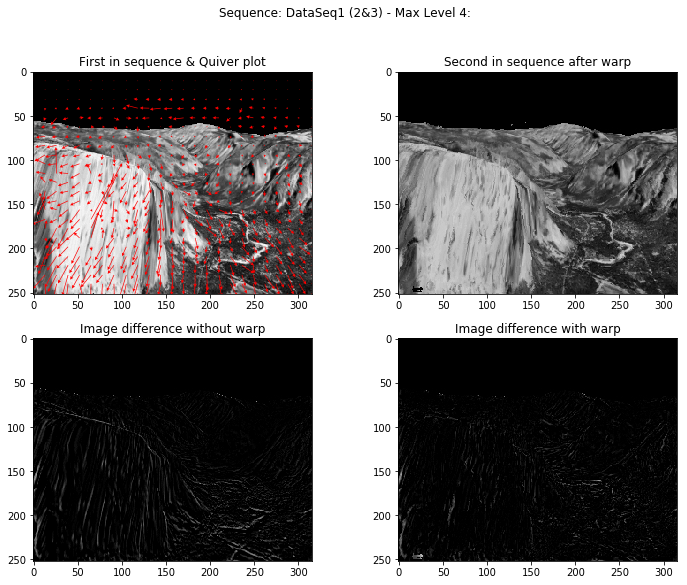

In [35]:
_,_ = hierarchicalLK(ds1_img2, ds1_img3, 4, plot = True, seq_name = "DataSeq1 (2&3)")

### 3.c. Data Sequence 2

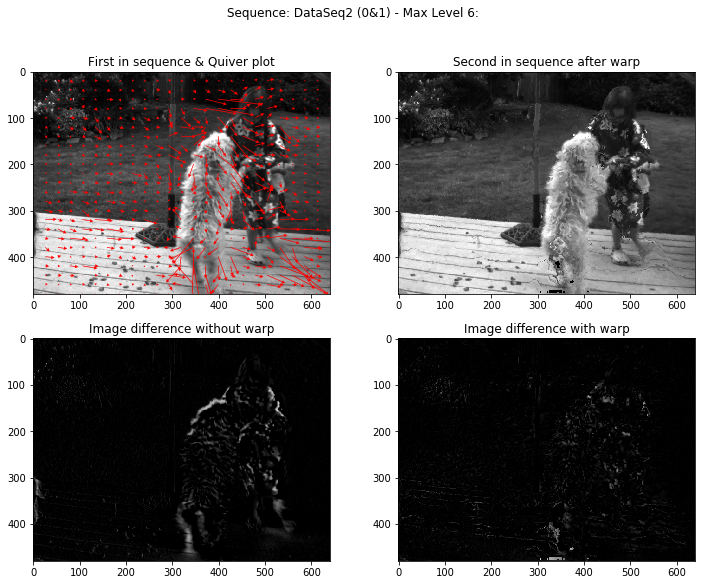

In [36]:
_,_ = hierarchicalLK(ds2_img0, ds2_img1, 6, plot = True, seq_name = "DataSeq2 (0&1)")

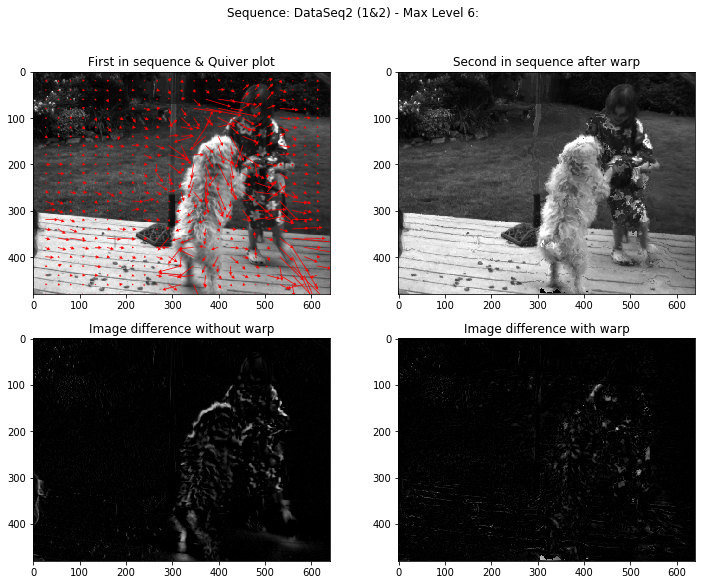

In [37]:
_,_ = hierarchicalLK(ds2_img1, ds2_img2, 6, plot = True, seq_name = "DataSeq2 (1&2)")

### 4. The Juggle Sequence

In [38]:
juggle_img0 = cv2.imread('./images/Juggle/0.png', cv2.IMREAD_GRAYSCALE)
juggle_img1 = cv2.imread('./images/Juggle/1.png', cv2.IMREAD_GRAYSCALE)
juggle_img2 = cv2.imread('./images/Juggle/2.png', cv2.IMREAD_GRAYSCALE)
#plt.imshow(juggle_img0, cmap='gray', vmin = 0, vmax = 255)

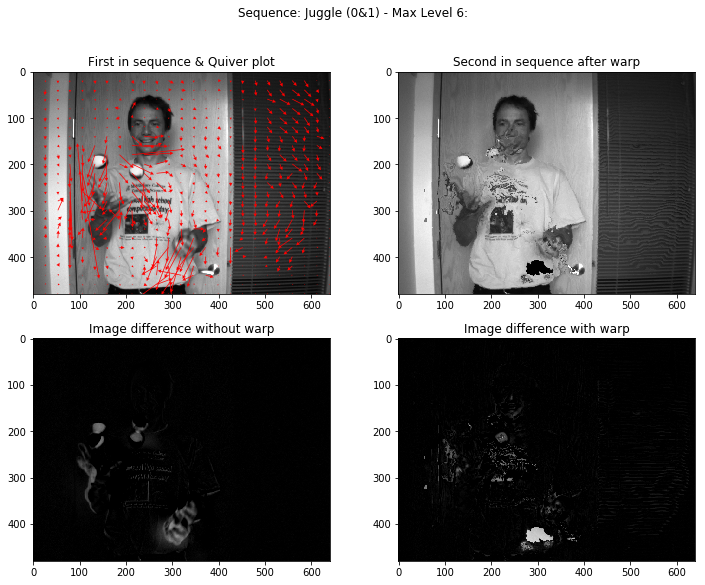

In [50]:
_,_ = hierarchicalLK(juggle_img0, juggle_img1, 6, plot = True, seq_name = "Juggle (0&1)")

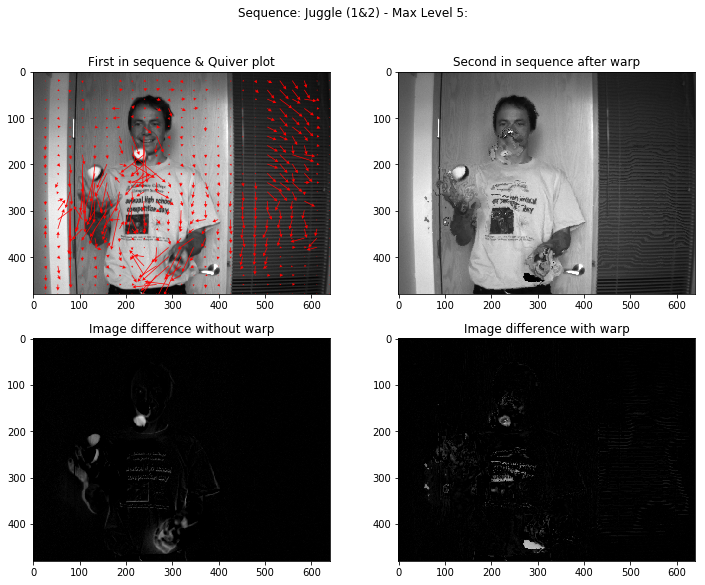

In [40]:
_,_ = hierarchicalLK(juggle_img1, juggle_img2, 5, plot = True, seq_name = "Juggle (1&2)")

Our main problem here comes from occlusion. Because the ball covers the face and the arm covers the T-shirt, recovering information is hard: we can see at those spots the blur resulting from shifts.


### 5. The Taxi Sequence

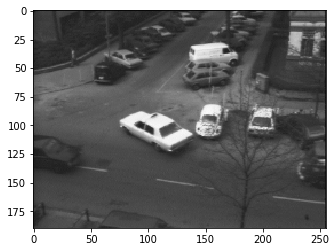

In [41]:
taxi = []
for i in np.arange(20):
    taxi.append(cv2.imread('./images/Taxis/taxi-{:02d}.jpg'.format(i), cv2.IMREAD_GRAYSCALE))
plt.imshow(taxi[0], cmap='gray', vmin = 0, vmax = 255)

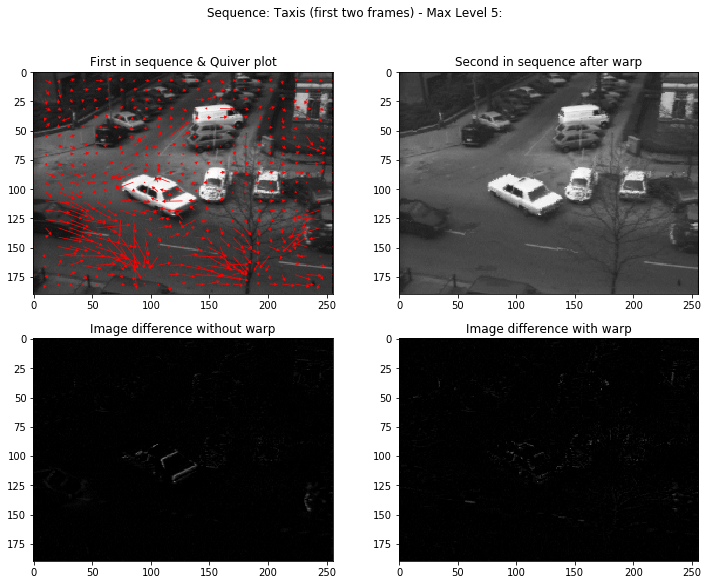

In [42]:
taxis_U = []
taxis_V = []
for i in np.arange(1,20):
    U, V = hierarchicalLK(taxi[i-1], taxi[i], 5)
    taxis_U.append(U)
    taxis_V.append(V)
_,_ = hierarchicalLK(taxi[0], taxi[1], 5, plot=True, seq_name="Taxis (first two frames)")

We're going to consider only translations based on our optical flow for the model.

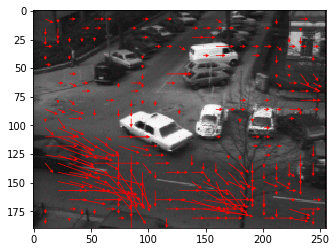

<module 'matplotlib.pyplot' from 'C:\Python27\lib\site-packages\matplotlib\pyplot.pyc'>

In [43]:
u = taxis_U[0]
v = taxis_V[0]
u_thresh = np.where(u > u.max() * 0.05, u, 0) 
v_thresh = np.where(v > v.max() * 0.05, v, 0) 
quiver_plot(u_thresh, v_thresh, taxi[0], showFig = True)

10% of the max flow seems like a good cutoff point.

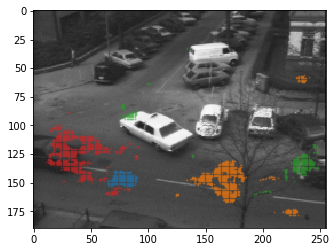

In [51]:
n_row, n_col = taxi[0].shape
rows = np.arange(n_row)
cols = np.arange(n_col)
cross = np.array([[r, c] for c in cols for r in rows]).reshape(-1,2)
df = pd.DataFrame(data = {'row': cross[:,0], 'col': cross[:,1], 'u': u[cross[:,0], cross[:,1]], 'v': v[cross[:,0], cross[:,1]]})
scaler = StandardScaler()
df_s = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_s = df_s[(df_s['u'] > df_s['u'].max() * 0.1) & (df_s['v'] != df_s['v'].max() * 0.1)]
df = pd.DataFrame(scaler.inverse_transform(df_s), columns=df_s.columns)

np.random.seed(903424427)
inertia = []
for k in np.arange(2, 10):
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(df_s)
    inertia.append(km.inertia_)
    
k = kneed.KneeLocator(np.arange(2,10), inertia, curve='convex', direction='decreasing').knee

for i in np.arange(k):
    plt.scatter(df.loc[clusters == i, 'col'], df.loc[clusters == i, 'row'], s = 1, alpha = 0.3)
plt.imshow(taxi[0], cmap='gray', vmin = 0, vmax = 255)

We grouped our motion according to values of optical flow U and V, but also encouraged grouping by local motion by adding constraints on similarity of rows and columns pixels across members of a same group.

On the last four images :  

In [45]:
def Group(index, threshold = 0.1, pltObj=None):
    u = taxis_U[index]
    v = taxis_V[index]

    n_row, n_col = taxi[index].shape
    rows = np.arange(n_row)
    cols = np.arange(n_col)
    cross = np.array([[r, c] for c in cols for r in rows]).reshape(-1,2)
    df = pd.DataFrame(data = {'row': cross[:,0], 'col': cross[:,1], 'u': u[cross[:,0], cross[:,1]], 'v': v[cross[:,0], cross[:,1]]})
    scaler = StandardScaler()
    df_s = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_s = df_s[(df_s['u'] > df_s['u'].max() * threshold) & (df_s['v'] != df_s['v'].max() * threshold)]
    df = pd.DataFrame(scaler.inverse_transform(df_s), columns=df_s.columns)

    np.random.seed(903424427)
    inertia = []
    for k in np.arange(2, 10):
        km = KMeans(n_clusters=k)
        clusters = km.fit_predict(df_s)
        inertia.append(km.inertia_)

    k = kneed.KneeLocator(np.arange(2,10), inertia, curve='convex', direction='decreasing').knee

    if pltObj is None:
        plt.figure()

    for i in np.arange(k):
        plt.scatter(df.loc[clusters == i, 'col'], df.loc[clusters == i, 'row'], s = 1, alpha = 0.3)
    plt.imshow(taxi[index], cmap='gray', vmin = 0, vmax = 255)

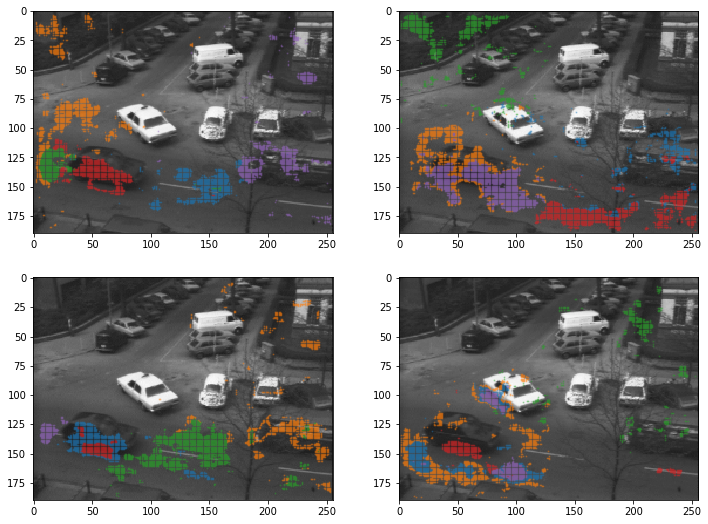

In [46]:
plt.figure(figsize=(12, 9))
for i in np.arange(1,5):
    plt.subplot(2,2,i)
    Group(19-i, threshold=0.05, pltObj = plt)